In [192]:
#크롤링한 데이터 불러오자~ 
import pandas as pd
documents_patent=pd.read_csv(r"C:\Users\eric\Desktop\Self_Driving_Patent_recent_5years.csv",header=0,encoding = 'unicode_escape')
len(documents_patent)

3920

In [193]:
# 어디보자~
documents_patent.head(10)

,ipc_list,patent_abstract,patent_date,patent_number,patent_title
0,"['G01C', 'G05D', 'G06Q', 'G07B']",A delivery server may generate two separate se...,2018-06-19,US10002466,Method and system for providing autonomous car...
1,"['G01C', 'G05D', 'G08G', 'H04B', 'H04W']","Methods, apparatuses, and non-transitory compu...",2018-10-30,US10115305,Optimizing autonomous car's driving time and u...
2,"['B61D', 'B61L', 'E01B']",An ballast consist for unloading ballast alon...,2018-11-27,US10138603,Autonomous ballast unloading consist
3,"['B61D', 'B61L', 'G05D']",Method and apparatus are disclosed for seque...,2018-12-04,US10146226,Autonomous vehicle sequential railcar loading ...
4,['B62D'],The present embodiments relate to a system and...,2019-01-22,US10183697,System and method for controlling autonomous s...
5,"['A61M', 'G05D']",An is provided that includes an control sy...,2015-07-14,US9081382,Autonomous vehicle comprising extracorporeal b...
6,"['A61M', 'B60W', 'G01C', 'G05D']",An is provided that includes an control sy...,2015-09-08,US9128484,Autonomous vehicle comprising extracorporeal b...
7,"['A61M', 'B60W', 'G05D']",An is provided that includes an control sy...,2015-09-08,US9128485,Autonomous vehicle comprising extracorporeal b...
8,"['B08B', 'B60S', 'B60W', 'B62D', 'B64C', 'B64D...",A method for ly a motor in a wash as well a...,2015-09-15,US9132807,Autonomous operation of a motor vehicle in a c...
9,"['B60Q', 'B60S', 'B60W', 'B62D', 'G05D', 'G08G']",A method for ly a motor in a wash to enhanc...,2016-10-25,US9477225,Method for autonomous driving in a car wash an...


In [102]:
# documents_patent.rename(columns={'patent_abstract': '0'}, inplace=True)

In [147]:
# documents.to_csv(r'C:\Users\eric\Desktop\documents.csv', index=False)

In [148]:
# documents=pd.read_csv(r"C:\Users\eric\Desktop\documents.csv",header=0,encoding = 'unicode_escape')
# documents.head()

In [116]:
#import package
import re
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora,models
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from stop_words import get_stop_words
from nltk.corpus import stopwords

In [107]:
Lem = WordNetLemmatizer()

In [223]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(Lem.lemmatize(token,pos="n"))
    return result

In [224]:
processed_docs = documents_patent['patent_abstract'].map(preprocess)
processed_docs[:10]

0    [delivery, server, generate, separate, securit...
1    [method, apparatus, transitory, readable, stor...
2    [ballast, consist, unloading, ballast, railway...
3    [method, apparatus, disclosed, sequential, loa...
4    [present, embodiment, relate, method, controll...
5    [provided, includes, control, dialysis, machin...
6    [provided, includes, control, dialysis, machin...
7    [provided, includes, control, dialysis, machin...
8    [method, motor, wash, corresponding, wash, pro...
9    [method, motor, wash, enhance, comfort, safety...
Name: patent_abstract, dtype: object

In [225]:
stop_words = stopwords.words('english')
stop_words_selfD = ['self', 'driving', 'car', 'autonomous','vehicle ', 'vehicle','driverless','\'','\'a',"'"]
stop_words.extend(stop_words_selfD)

In [244]:
len(stop_words)

189

In [226]:
# 불용어제거하자~
stopped_processed_docs = []
for word in processed_docs:
    if word not in stop_words:
        stopped_processed_docs.append(word)
        

In [154]:
# stopped_processed_docs[0]

In [227]:
dictionary = gensim.corpora.Dictionary(stopped_processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 authenticate
1 automatically
2 code
3 combination
4 combined
5 comparing
6 create
7 delivery
8 exchange
9 following
10 generate


In [228]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [229]:
bow_corpus = [dictionary.doc2bow(doc) for doc in stopped_processed_docs]

In [158]:
# 필요한 팩히지 로드~~~
import json
import warnings
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import time
from tqdm import tqdm

In [159]:
# 패스별 코히 확인
coherences=[]
perplexities=[]
passes=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(20)):
    
    ntopics, nwords = 10, 10
    if i==0:
        p=5
    else:
        p=(i+1)*5
    tic = time.time()
    lda4 = gensim.models.LdaMulticore(bow_corpus, num_topics=ntopics, id2word=dictionary, passes=p, workers=4)
    print('epoch',p,time.time() - tic)
    passes.append(p)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=bow_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
#     print('Perplexity: ', lda4.log_perplexity(bow_corpus),'\n\n')
#     perplexities.append(lda4.log_perplexity(bow_corpus))


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

epoch 5 29.89413857460022
Cpherence -2.3545572945203554



  5%|████▏                                                                              | 1/20 [00:30<09:30, 30.01s/it]

epoch 10 49.359002351760864
Cpherence -2.7422372068058984



 10%|████████▎                                                                          | 2/20 [01:19<10:45, 35.84s/it]

epoch 15 67.94636583328247
Cpherence -2.7040758143239207



 15%|████████████▍                                                                      | 3/20 [02:27<12:53, 45.50s/it]

epoch 20 87.25960803031921
Cpherence -2.4377962733042486



 20%|████████████████▌                                                                  | 4/20 [03:54<15:28, 58.05s/it]

epoch 25 106.13910460472107
Cpherence -2.3689784806977148



 25%|████████████████████▊                                                              | 5/20 [05:41<18:07, 72.51s/it]

epoch 30 119.44970083236694
Cpherence -2.231144555321933



 30%|████████████████████████▉                                                          | 6/20 [07:40<20:12, 86.62s/it]

epoch 35 146.53903913497925
Cpherence -2.5336830388011604



 35%|████████████████████████████▋                                                     | 7/20 [10:07<22:40, 104.63s/it]

epoch 40 173.03006052970886
Cpherence -2.4282307447190465



 40%|████████████████████████████████▊                                                 | 8/20 [13:00<25:02, 125.17s/it]

epoch 45 181.9682948589325
Cpherence -2.480619136080056



 45%|████████████████████████████████████▉                                             | 9/20 [16:02<26:04, 142.24s/it]

epoch 50 198.02634239196777
Cpherence -2.8039116697852724



 50%|████████████████████████████████████████▌                                        | 10/20 [19:20<26:30, 159.01s/it]

epoch 55 219.1769962310791
Cpherence -2.493605454182658



 55%|████████████████████████████████████████████▌                                    | 11/20 [22:59<26:33, 177.08s/it]

epoch 60 235.40136861801147
Cpherence -2.4893753292313034



 60%|████████████████████████████████████████████████▌                                | 12/20 [26:55<25:56, 194.61s/it]

epoch 65 275.3312773704529
Cpherence -2.533386021983392



 65%|████████████████████████████████████████████████████▋                            | 13/20 [31:30<25:31, 218.86s/it]

epoch 70 299.8489863872528
Cpherence -2.3323504981839704



 70%|████████████████████████████████████████████████████████▋                        | 14/20 [36:30<24:19, 243.18s/it]

epoch 75 321.8359022140503
Cpherence -2.2611019548905196



 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [41:52<22:14, 266.81s/it]

epoch 80 338.35583305358887
Cpherence -2.574899034383721



 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [47:31<19:13, 288.30s/it]

epoch 85 372.51707911491394
Cpherence -2.5515569221544694



 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [53:43<15:40, 313.60s/it]

epoch 90 382.70464277267456
Cpherence -2.5830067464949087



 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:00:06<11:08, 334.36s/it]

epoch 95 394.2855689525604
Cpherence -2.213337762560566



 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:06:40<05:52, 352.37s/it]

epoch 100 432.1385486125946
Cpherence -2.4310924837356778



100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:13:53<00:00, 376.33s/it]

In [160]:
# for pyplot
import matplotlib.pyplot as plt

Text(0.5, 0, 'passes')

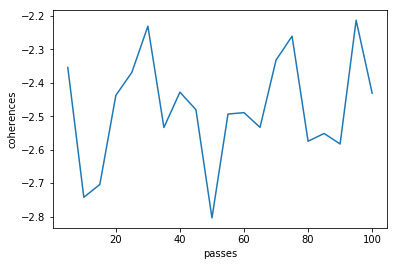

In [161]:
plt.plot(passes,coherences)
plt.ylabel('coherences')
plt.xlabel('passes')

In [178]:
# 토픽별 코히 확인
coherencesT=[]
ntopics_=[]
warnings.filterwarnings('ignore')
lda_model=[]
for i in tqdm(range(20)):
    if i==0:
        ntopics = 5
    else:
        ntopics = 5*(i+1)
    nwords = 10
    tic = time.time()
    lda_ntopics = gensim.models.LdaMulticore(bow_corpus, num_topics=ntopics, id2word=dictionary, iterations=1000, passes=95, workers=4,random_state=42)
    print(lda_ntopics)
    lda_model.append(lda_ntopics)
    print('ntopics',ntopics,time.time() - tic)
    ntopics_.append(ntopics)
    cm = CoherenceModel(model=lda_ntopics, corpus=bow_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherencesT.append(coherence)








  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

LdaModel(num_terms=1370, num_topics=5, decay=0.5, chunksize=2000)
ntopics 5 407.1623446941376
Cpherence -2.047103433435815








  5%|████                                                                            | 1/20 [06:47<2:08:57, 407.24s/it]

LdaModel(num_terms=1370, num_topics=10, decay=0.5, chunksize=2000)
ntopics 10 402.4186534881592
Cpherence -2.5331657608445752








 10%|████████                                                                        | 2/20 [13:29<2:01:44, 405.83s/it]

LdaModel(num_terms=1370, num_topics=15, decay=0.5, chunksize=2000)
ntopics 15 383.01657795906067
Cpherence -2.809689533444091








 15%|████████████                                                                    | 3/20 [19:52<1:53:03, 399.02s/it]

LdaModel(num_terms=1370, num_topics=20, decay=0.5, chunksize=2000)
ntopics 20 372.0568497180939
Cpherence -3.127348624842386








 20%|████████████████                                                                | 4/20 [26:05<1:44:15, 390.97s/it]

LdaModel(num_terms=1370, num_topics=25, decay=0.5, chunksize=2000)
ntopics 25 363.14270305633545
Cpherence -3.525747219702164








 25%|████████████████████                                                            | 5/20 [32:08<1:35:39, 382.66s/it]

LdaModel(num_terms=1370, num_topics=30, decay=0.5, chunksize=2000)
ntopics 30 352.78967332839966
Cpherence -3.4945025542793298








 30%|████████████████████████                                                        | 6/20 [38:01<1:27:12, 373.74s/it]

LdaModel(num_terms=1370, num_topics=35, decay=0.5, chunksize=2000)
ntopics 35 347.23927092552185
Cpherence -3.8990475395741817








 35%|████████████████████████████                                                    | 7/20 [43:48<1:19:15, 365.84s/it]

LdaModel(num_terms=1370, num_topics=40, decay=0.5, chunksize=2000)
ntopics 40 372.63929891586304
Cpherence -3.7959925412671893








 40%|████████████████████████████████                                                | 8/20 [50:01<1:13:35, 367.93s/it]

LdaModel(num_terms=1370, num_topics=45, decay=0.5, chunksize=2000)
ntopics 45 372.1685619354248
Cpherence -3.9066458422114074








 45%|████████████████████████████████████                                            | 9/20 [56:13<1:07:41, 369.26s/it]

LdaModel(num_terms=1370, num_topics=50, decay=0.5, chunksize=2000)
ntopics 50 367.1968972682953
Cpherence -4.031271949705619








 50%|██████████████████████████████████████▌                                      | 10/20 [1:02:21<1:01:26, 368.69s/it]

LdaModel(num_terms=1370, num_topics=55, decay=0.5, chunksize=2000)
ntopics 55 360.70622181892395
Cpherence -4.046061304138443








 55%|███████████████████████████████████████████▍                                   | 11/20 [1:08:22<54:57, 366.36s/it]

LdaModel(num_terms=1370, num_topics=60, decay=0.5, chunksize=2000)
ntopics 60 359.64904832839966
Cpherence -4.252298912292939








 60%|███████████████████████████████████████████████▍                               | 12/20 [1:14:21<48:35, 364.41s/it]

LdaModel(num_terms=1370, num_topics=65, decay=0.5, chunksize=2000)
ntopics 65 362.18526434898376
Cpherence -4.4284898465084295








 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:20:24<42:26, 363.80s/it]

LdaModel(num_terms=1370, num_topics=70, decay=0.5, chunksize=2000)
ntopics 70 366.6383624076843
Cpherence -4.618498246852731








 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:26:31<36:28, 364.72s/it]

LdaModel(num_terms=1370, num_topics=75, decay=0.5, chunksize=2000)
ntopics 75 395.6427733898163
Cpherence -4.455702745314529








 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:33:07<31:10, 374.06s/it]

LdaModel(num_terms=1370, num_topics=80, decay=0.5, chunksize=2000)
ntopics 80 491.8514699935913
Cpherence -4.479696379733107








 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:41:19<27:17, 409.47s/it]

LdaModel(num_terms=1370, num_topics=85, decay=0.5, chunksize=2000)
ntopics 85 521.9978120326996
Cpherence -4.625242684400287








 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:50:01<22:09, 443.31s/it]

LdaModel(num_terms=1370, num_topics=90, decay=0.5, chunksize=2000)
ntopics 90 537.8753461837769
Cpherence -4.496695692653806








 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:58:59<15:43, 471.75s/it]

LdaModel(num_terms=1370, num_topics=95, decay=0.5, chunksize=2000)
ntopics 95 537.5661633014679
Cpherence -4.624930628784678








 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:07:57<08:11, 491.57s/it]

LdaModel(num_terms=1370, num_topics=100, decay=0.5, chunksize=2000)
ntopics 100 413.4451570510864
Cpherence -4.718745719169625








100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:14:51<00:00, 468.21s/it]

Text(0.5, 0, 'ntopics')

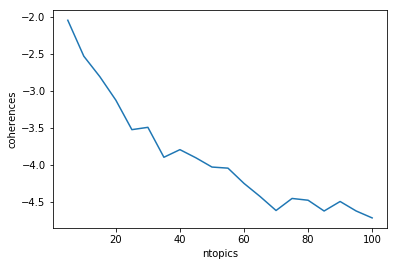

In [179]:
# 코히 확인
plt.plot(ntopics_,coherencesT)
plt.ylabel('coherences')
plt.xlabel('ntopics')

In [183]:
coherencesT_1=[]
ntopics_1=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(6)):
    if i==0:
        ntopics = 5
    else:
        ntopics = (i+5)
    nwords = 10
    tic = time.time()
    lda_ntopics = gensim.models.LdaMulticore(bow_corpus, num_topics=ntopics, id2word=dictionary, iterations=1000, passes=95, workers=4,random_state=42)
    print('ntopics',ntopics,time.time() - tic)
    ntopics_1.append(ntopics)
    cm = CoherenceModel(model=lda_ntopics, corpus=bow_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherencesT_1.append(coherence)








  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

ntopics 5 409.959374666214
Cpherence -2.047103433435815








 17%|█████████████▊                                                                     | 1/6 [06:50<34:10, 410.03s/it]

ntopics 6 400.6792998313904
Cpherence -2.135585065003671








 33%|███████████████████████████▋                                                       | 2/6 [13:30<27:08, 407.25s/it]

ntopics 7 395.78043818473816
Cpherence -2.0590942036052753








 50%|█████████████████████████████████████████▌                                         | 3/6 [20:06<20:11, 403.83s/it]

ntopics 8 411.1692485809326
Cpherence -2.21914591548658








 67%|███████████████████████████████████████████████████████▎                           | 4/6 [26:57<13:32, 406.06s/it]

ntopics 9 398.7724072933197
Cpherence -2.276676461008442








 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [33:36<06:43, 403.90s/it]

ntopics 10 401.3844087123871
Cpherence -2.5331657608445752








100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [40:18<00:00, 403.17s/it]

Text(0.5, 0, 'ntopics')

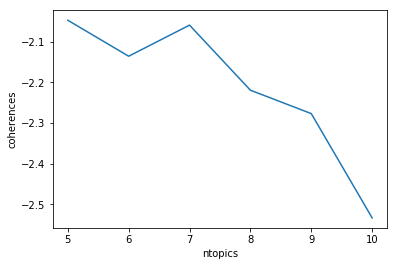

In [222]:
# 코히 확인
plt.plot(ntopics_1,coherencesT_1)
plt.ylabel('coherences')
plt.xlabel('ntopics')

In [221]:
##############################  모델 적용 ###############################

In [235]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10
                                       , id2word=dictionary, passes=95, workers=4,random_state=42)

In [241]:
cm = CoherenceModel(model=lda_model, corpus=bow_corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)

Cpherence -2.6004974144755724


In [242]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"wheel" + 0.021*"assembly" + 0.017*"body" + 0.016*"includes" + 0.014*"device" + 0.014*"member" + 0.012*"second" + 0.011*"having" + 0.011*"frame" + 0.011*"position"
Topic: 1 
Words: 0.045*"information" + 0.027*"based" + 0.026*"location" + 0.025*"method" + 0.022*"path" + 0.021*"position" + 0.018*"route" + 0.014*"data" + 0.014*"road" + 0.014*"lane"
Topic: 2 
Words: 0.041*"device" + 0.029*"object" + 0.025*"traffic" + 0.019*"mean" + 0.017*"sensor" + 0.016*"method" + 0.016*"particular" + 0.013*"invention" + 0.012*"fuel" + 0.011*"example"
Topic: 3 
Words: 0.045*"control" + 0.041*"mode" + 0.017*"user" + 0.014*"display" + 0.014*"processor" + 0.013*"condition" + 0.013*"manual" + 0.012*"communication" + 0.012*"passenger" + 0.012*"method"
Topic: 4 
Words: 0.059*"circuit" + 0.036*"signal" + 0.028*"touch" + 0.026*"voltage" + 0.024*"electrode" + 0.019*"device" + 0.019*"sensing" + 0.019*"output" + 0.017*"control" + 0.016*"input"
Topic: 5 
Words: 0.041*"data" + 0.023*"control" + 

In [243]:
# pca를 이용한 lda 시각화
import pyLDAvis.gensim as gensimvis

prepared_data = gensimvis.prepare(lda_model, bow_corpus, dictionary) #lda 모델 바꾸자

In [245]:
pyLDAvis.display(prepared_data)

In [210]:
def finding_dominant_topic(corpus, model):
    topic_num_list= []
    prob_topic_list= []
    keyword_list= []
    for i, row in enumerate(model[corpus]):
        row= sorted(row, key= lambda x: (x[1]), reverse= True)
        for j, (topic_num, prob_topic) in enumerate(row):
            if j== 0:
                wp= model.show_topic(topic_num)
                topic_num_list.append(int(topic_num))
                prob_topic_list.append(round(prob_topic, 4))
                keyword_list.append(", ".join([word for word, prob in wp]))
            else:
                break
    result= {}
    result['dominant_topic']= topic_num_list
    result['prob_topic']= prob_topic_list
    result['keyword_list']= keyword_list
    result= pd.DataFrame(result, columns= ['dominant_topic', 'prob_topic', 'keyword_list'])
    return result

In [215]:
table=finding_dominant_topic(bow_corpus,lda_model)

In [220]:
#t1-->4
#t2-->6
#t3-->7
#t4-->1
#t5-->3
#t6-->9
#t7-->2
#t8-->5
#t9-->8
#t10-->0         반대로 읽기  & 테이블 csv 번호 == 원데이터 번호 (순서 같다 2면 2)

In [219]:
table.head()

,dominant_topic,prob_topic,keyword_list
0,9,0.3268,"data, sensor, park, position, detect, base, se..."
1,6,0.6103,"determine, information, base, device, location..."
2,8,0.3053,"control, clean, configure, robot, transport, s..."
3,2,0.5068,"provide, communication, signal, control, remot..."
4,5,0.4902,"steer, wheel, control, speed, second, angle, c..."


In [216]:
table.to_csv(r'C:\Users\eric\Desktop\dominant_topic_10.csv', index=False,encoding='utf8')

In [217]:
##################################################################################################

In [230]:
lda_model_7 = gensim.models.LdaMulticore(bow_corpus, num_topics=7
                                       , id2word=dictionary, passes=95, workers=4,random_state=42)

In [231]:
cm = CoherenceModel(model=lda_model_7, corpus=bow_corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence,-2.05)

Cpherence -2.812722315150372 -2.05


In [246]:
def topic_keyword(model, num_topics, topn= 10):
    topic_num_list= []
    keyword_list= []
    for num in range(0, num_topics):
        keyword= ", ".join([word for word, prob in model.show_topic(topicid= num, topn= topn)])
        topic_num_list.append(num)
        keyword_list.append(keyword)
    result= {}
    result['topic_num']= topic_num_list
    result['keyword']= keyword_list
    result= pd.DataFrame(result, columns= ['topic_num', 'keyword'])
    return result

In [247]:
result_keyword=topic_keyword(lda_model_7,num_topics=7,topn= 10)

In [253]:
for i in range(7):
    print(result_keyword.keyword[i])

wheel, assembly, device, includes, body, member, second, position, frame, motor
information, object, based, data, method, sensor, image, position, path, lane
cleaning, surface, robot, traffic, includes, configured, zone, sensor, unmanned, signal
control, mode, user, method, configured, device, processor, parking, includes, information
signal, circuit, light, voltage, output, device, line, includes, display, unit
data, operation, sensor, based, method, device, time, level, second, value
power, motor, control, steering, module, unit, engine, electric, supply, device


In [232]:
for idx, topic in lda_model_7.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"wheel" + 0.020*"assembly" + 0.017*"device" + 0.016*"includes" + 0.016*"body" + 0.014*"member" + 0.013*"second" + 0.012*"position" + 0.011*"frame" + 0.011*"motor"
Topic: 1 
Words: 0.029*"information" + 0.027*"object" + 0.024*"based" + 0.023*"data" + 0.021*"method" + 0.021*"sensor" + 0.016*"image" + 0.015*"position" + 0.014*"path" + 0.014*"lane"
Topic: 2 
Words: 0.027*"cleaning" + 0.026*"surface" + 0.026*"robot" + 0.021*"traffic" + 0.018*"includes" + 0.018*"configured" + 0.018*"zone" + 0.016*"sensor" + 0.014*"unmanned" + 0.014*"signal"
Topic: 3 
Words: 0.045*"control" + 0.039*"mode" + 0.015*"user" + 0.014*"method" + 0.013*"configured" + 0.013*"device" + 0.013*"processor" + 0.013*"parking" + 0.012*"includes" + 0.012*"information"
Topic: 4 
Words: 0.060*"signal" + 0.037*"circuit" + 0.026*"light" + 0.018*"voltage" + 0.017*"output" + 0.017*"device" + 0.016*"line" + 0.016*"includes" + 0.015*"display" + 0.015*"unit"
Topic: 5 
Words: 0.044*"data" + 0.018*"operation" + 0.

In [233]:
prepared_data_7 = gensimvis.prepare(lda_model_7, bow_corpus, dictionary)

In [234]:
pyLDAvis.display(prepared_data_7)

In [261]:
pyLDAvis.save_html(prepared_data_7, "C:\\Users\\eric\\Desktop\\eric.html")

In [236]:
table=finding_dominant_topic(bow_corpus,lda_model_7)

In [218]:
#t1-->0
#t2-->1
#t3-->3
#t4-->6
#t5-->5
#t6-->4
#t7-->2              반대로 읽기  & 테이블 csv 번호 == 원데이터 번호 (순서 같다 2면 2)

In [238]:
table.head()

,dominant_topic,prob_topic,keyword_list
0,3,0.7661,"control, mode, user, method, configured, devic..."
1,1,0.8169,"information, object, based, data, method, sens..."
2,3,0.3929,"control, mode, user, method, configured, devic..."
3,3,0.3952,"control, mode, user, method, configured, devic..."
4,6,0.8635,"power, motor, control, steering, module, unit,..."


In [239]:
len(table)

3920

In [240]:
table.to_csv(r'C:\Users\eric\Desktop\dominant_topic_7_noun.csv', index=False,encoding='utf8')